# Coarse vs Fine Experiments

This notebook runs parallel experiments for fine neural networks vs coarse neural network on various datasets.

In [22]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
from pathlib import Path

from coarse_vs_fine_utils import (
    load_kmnist, class_sizer, coarser, weights_creator, class_exchanger,
    LinearLearningRateScheduler, run_experiment
)

## Configuration

In [23]:
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# experiment parameters
EXPERIMENTS = 30
LAYERS = [5, 7, 10, 20, 25, 30, 50, 75, 100, 120]
SIZES = [50, 100, 150, 200, 300, 500, 1000, 1500]
EPOCHS = [700]
EP_OF_DIMINISH_LIST = [50]
DECAY_RATE_LIST = [0.7]
INITIAL_LEARNING_RATES_LIST = [0.01]

# dataset configuration
DATASETS = ['kmnist']     # options: 'cifar10', 'fmnist', 'kmnist', 'mnist'
MODE = 'both'             # options: 'variable_layer', 'variable_size', 'both'
LR_VERSION = 'customized' # options: 'decay', 'constant', 'customized'

# model parameters
N_CLASSES_FINE = 8
VAL_SIZE = 0.1
VERBOSE = 0

## Data Loading Functions

In [24]:
def load_dataset(dataset_name):
    """Load and preprocess dataset"""
    
    if dataset_name == 'cifar10':
        (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
        y_train = y_train.reshape((X_train.shape[0]))
        y_test = y_test.reshape((X_test.shape[0]))
        
    elif dataset_name == 'mnist':
        (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
        
    elif dataset_name == 'fmnist':
        (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
        
    elif dataset_name == 'kmnist':
        X_train, y_train, X_test, y_test = load_kmnist()
        
        X_train = X_train.reshape((60000, 28, 28))
        X_test = X_test.reshape((10000, 28, 28))
    
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    return X_train, y_train, X_test, y_test


def preprocess_dataset(X_train, y_train, X_test, y_test, dataset_name):
    """Preprocess dataset for 8-class experiments"""
    
    if dataset_name == 'fmnist':
        indices_to_remove = np.where((y_train == 0) | (y_train == 1))[0]
        X_train = np.delete(X_train, indices_to_remove, axis=0)
        y_train = np.delete(y_train, indices_to_remove, axis=0)
        y_train = y_train - 2
        
        indices_to_remove = np.where((y_test == 0) | (y_test == 1))[0]
        X_test = np.delete(X_test, indices_to_remove, axis=0)
        y_test = np.delete(y_test, indices_to_remove, axis=0)
        y_test = y_test - 2
        
        y_train = class_exchanger(y_train, 3, 4)
        y_test = class_exchanger(y_test, 3, 4)
        
        conf = np.array([0, 1, 0, 1, 0, 1, 0, 1])
        
    elif dataset_name == 'cifar10':
        train_indices_to_remove = np.where((y_train == 6) | (y_train == 7))[0]
        X_train = np.delete(X_train, train_indices_to_remove, axis=0)
        y_train = np.delete(y_train, train_indices_to_remove, axis=0)
        y_train[y_train == 8] = 6
        y_train[y_train == 9] = 7
        
        test_indices_to_remove = np.where((y_test == 6) | (y_test == 7))[0]
        X_test = np.delete(X_test, test_indices_to_remove, axis=0)
        y_test = np.delete(y_test, test_indices_to_remove, axis=0)
        y_test[y_test == 8] = 6
        y_test[y_test == 9] = 7
        
        y_train = class_exchanger(y_train, 2, 6)
        y_test = class_exchanger(y_test, 3, 7)
        
        conf = np.array([0, 0, 0, 0, 1, 1, 1, 1])
        
    else:
        X_train = X_train[y_train < 8]
        y_train = y_train[y_train < 8]
        X_test = X_test[y_test < 8]
        y_test = y_test[y_test < 8]
        
        conf = np.array([0, 0, 0, 0, 1, 1, 1, 1])
    
    return X_train, y_train, X_test, y_test, conf

## Main Experiment Runner

In [25]:
def run_all_experiments(dataset, mode, X_fix, y_train, X_test, y_test, conf, n_classes_fine, 
                        val_size, verbose, lr_version, layers, sizes, decay_rate_list, 
                        ep_of_diminish_list, initial_learning_rates_list, epochs, experiments):
    
    experiment_configs = []
    for lay1 in layers:
        for size in sizes:
            if size < 100:
                bs = [8]
            elif size < 501:
                bs = [16]
            elif size < 1501:
                bs = [32]
            else:
                bs = [64]
                
            for bs_coarse in bs:
                for decay_rate in decay_rate_list:
                    for ep_of_diminish in ep_of_diminish_list:
                        for lr1 in initial_learning_rates_list:
                            for ep_coarse in epochs:
                                for exp in range(experiments):
                                    experiment_configs.append((lay1, size, bs_coarse, decay_rate, 
                                                              ep_of_diminish, lr1, ep_coarse, exp))
    
    n_jobs = min(multiprocessing.cpu_count() - 1, 4)
    print(f"Running {len(experiment_configs)} experiments in parallel using {n_jobs} CPU cores")
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(run_experiment)(
            lay1, size, bs_coarse, decay_rate, ep_of_diminish, lr1, ep_coarse, exp,
            X_fix, y_train, X_test, y_test, conf, n_classes_fine, val_size, verbose, lr_version, dataset
        ) for lay1, size, bs_coarse, decay_rate, ep_of_diminish, lr1, ep_coarse, exp in experiment_configs
    )
    
    data_df = pd.DataFrame(results)
    
    # save results
    output_dir = RESULTS_DIR / dataset
    output_dir.mkdir(exist_ok=True, parents=True)
    
    if mode == 'variable_layer':
        output_file = output_dir / f"{dataset}_{mode}_size={sizes[-1]}_results.csv"
    elif mode == 'variable_size':
        output_file = output_dir / f"{dataset}_{mode}_lay={layers[-1]}_results.csv"
    elif mode == 'both':
        output_file = output_dir / f"{dataset}_complete_results.csv"
        
    data_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
        
    return data_df

## Visualization Functions

In [26]:
def visualize_samples(X_train, y_train, n_samples=40):
    """Visualize dataset samples"""
    n_cols = 10
    n_rows = n_samples // n_cols
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 2))
    
    for i in range(n_samples):
        ax = axs.ravel()[i]
        if len(X_train[i].shape) == 2:  # grayscale
            ax.imshow(X_train[i], cmap='gray')
        else:  # RGB
            ax.imshow(X_train[i])
        ax.set_title(f'Class {int(y_train[i])}', fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## Run Experiments


Processing dataset: kmnist

KMNIST loaded: Train (60000, 28, 28), Test (10000, 28, 28)
Training samples: 48000
Test samples: 8000
Input shape: (28, 28)
Classes configuration: [0 0 0 0 1 1 1 1]


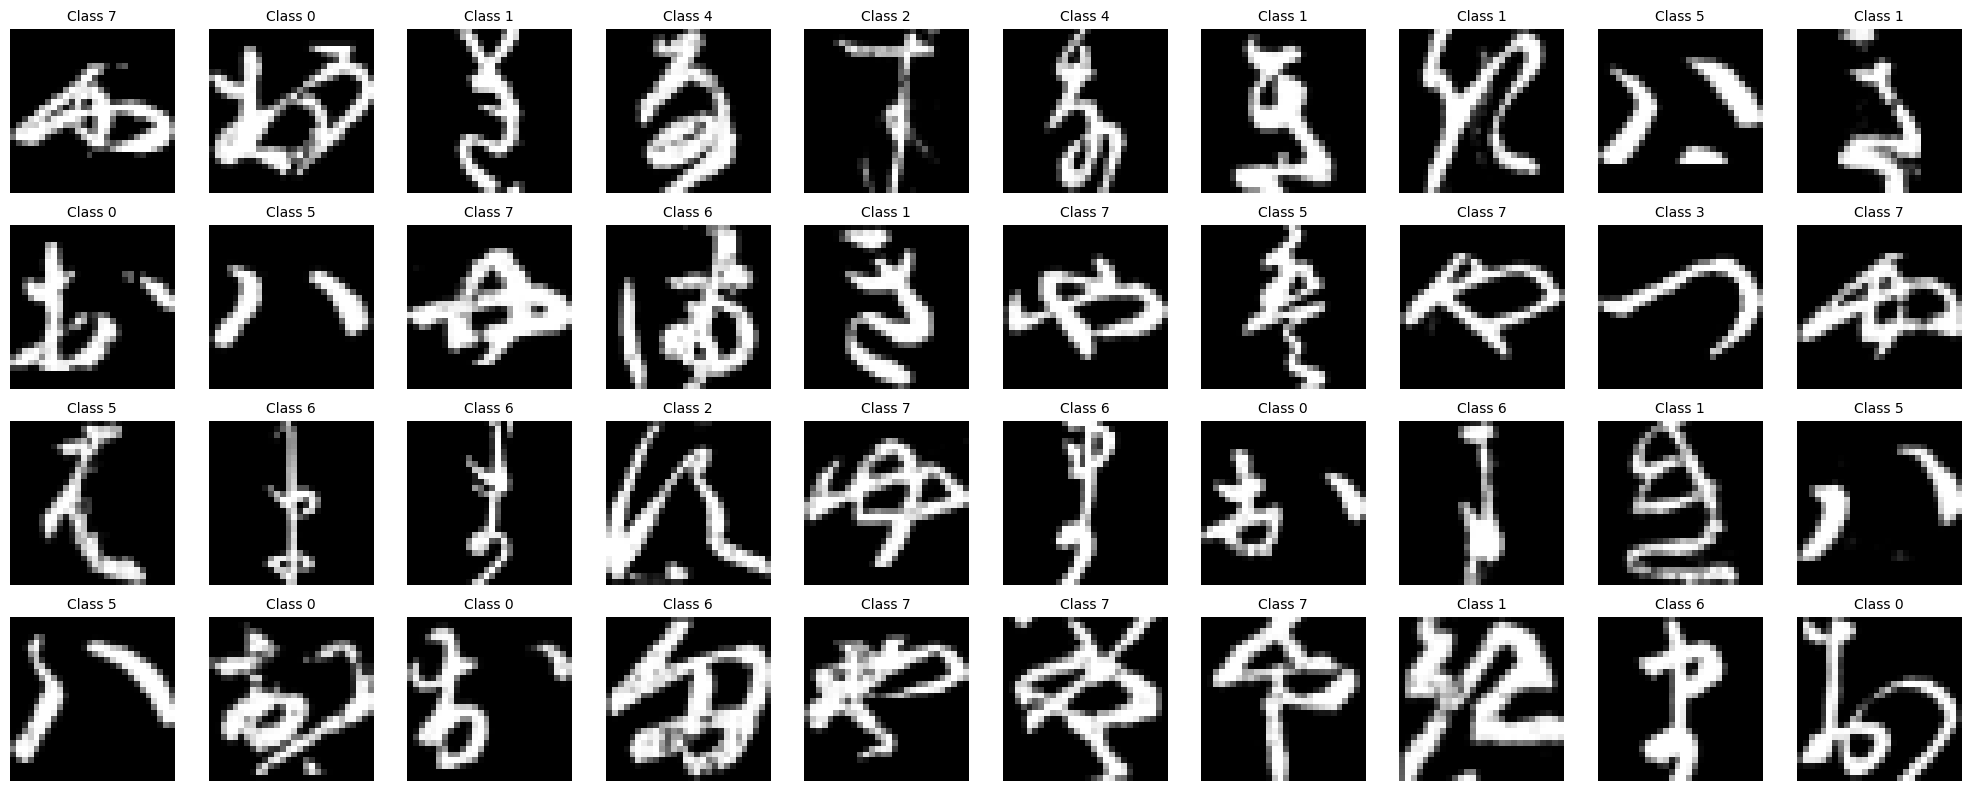

Running 2400 experiments in parallel using 4 CPU cores


/home/fmilanesio/miniconda3/envs/davide/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/fmilanesio/miniconda3/envs/davide/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/fmilanesio/miniconda3/envs/davide/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/fmilanesio/miniconda3/

In [ ]:
with tf.device('/CPU:0'):
    for dataset in DATASETS:
        print(f"\n{'='*50}")
        print(f"Processing dataset: {dataset}")
        print(f"{'='*50}\n")
        
        X_train, y_train, X_test, y_test = load_dataset(dataset)
        X_train, y_train, X_test, y_test, conf = preprocess_dataset(
            X_train, y_train, X_test, y_test, dataset
        )
        
        print(f"Training samples: {X_train.shape[0]}")
        print(f"Test samples: {X_test.shape[0]}")
        print(f"Input shape: {X_train[0].shape}")
        print(f"Classes configuration: {conf}")
        
        visualize_samples(X_train, y_train, n_samples=40)
        
        X_fix = np.copy(X_train)
        
        results_df = run_all_experiments(
            dataset, MODE, X_fix, y_train, X_test, y_test, conf, N_CLASSES_FINE,
            VAL_SIZE, VERBOSE, LR_VERSION, LAYERS, SIZES, DECAY_RATE_LIST,
            EP_OF_DIMINISH_LIST, INITIAL_LEARNING_RATES_LIST, EPOCHS, EXPERIMENTS
        )
        
        print(f"\nExperiments completed for {dataset}")

## Fine vs Coarse accuracy plot

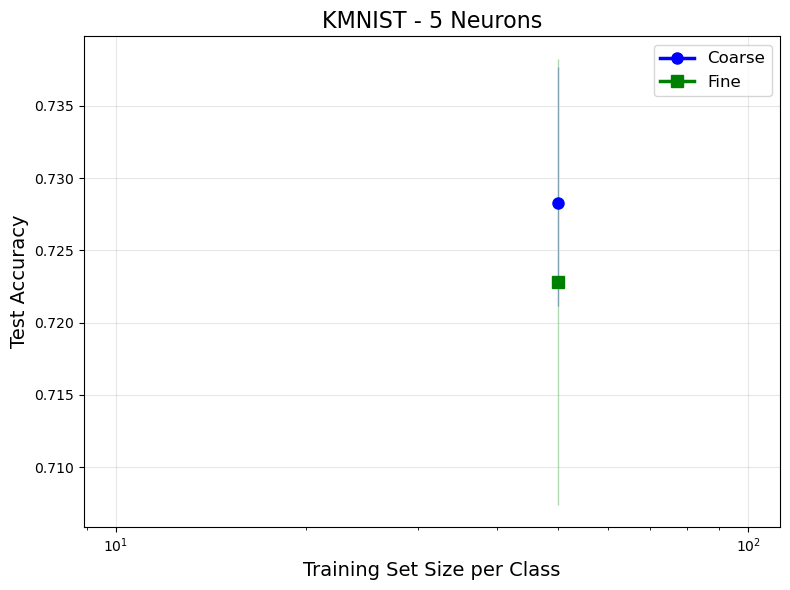

In [ ]:
# simple visualization for a fixed number of neurons
NODE_COUNT = 5  
DATASET = 'kmnist'

# load results
results_file = RESULTS_DIR / DATASET / f"{DATASET}_complete_results.csv"
df = pd.read_csv(results_file)

df_filtered = df[df['Nodes'] == NODE_COUNT]
sizes = sorted(df_filtered['Single_Class_Size'].unique())

# calculate quartiles for errorbars
Q1_coarse, Q2_coarse, Q3_coarse = [], [], []
Q1_fine, Q2_fine, Q3_fine = [], [], []

for size in sizes:
    size_data = df_filtered[df_filtered['Single_Class_Size'] == size]
    Q1_coarse.append(size_data['Accuracy_coarse'].quantile(0.25))
    Q2_coarse.append(size_data['Accuracy_coarse'].quantile(0.50))
    Q3_coarse.append(size_data['Accuracy_coarse'].quantile(0.75))
    Q1_fine.append(size_data['Accuracy_fine'].quantile(0.25))
    Q2_fine.append(size_data['Accuracy_fine'].quantile(0.50))
    Q3_fine.append(size_data['Accuracy_fine'].quantile(0.75))

plt.figure(figsize=(8, 6))
x = np.array(sizes)

plt.fill_between(x, Q1_coarse, Q3_coarse, color='blue', alpha=0.3)
plt.plot(x, Q2_coarse, 'b-o', linewidth=2.5, markersize=8, label='Coarse')

plt.fill_between(x, Q1_fine, Q3_fine, color='green', alpha=0.3)
plt.plot(x, Q2_fine, 'g-s', linewidth=2.5, markersize=8, label='Fine')

plt.xscale('log')
plt.xlabel('Training Set Size per Class', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.title(f'{DATASET.upper()} - {NODE_COUNT} Neurons', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
